In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets,LaTeXStrings   
using StatsFuns
using Zygote, Optim, ForwardDiff, Flux
using JLD
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, approximate_kernel_expectation, WishartFast, logdet
import RxInfer: PointMassFormConstraint,call_boundaries, call_starting_point

In [3]:
include("../GPnode/MultiSGPnode.jl")
include("../helper_functions/derivative_helper.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
function predict_gp(X_test, Xu, Yu, var_Yu,C, kernel)
    Kuu = kron(C,kernelmatrix(kernel,Xu))
    K_test_u =kron(C,kernelmatrix(kernel,X_test,Xu))
    Ktest =kron(C,kernelmatrix(kernel,X_test))

    μ = K_test_u * Yu 
    Σ = Ktest - K_test_u * inv(Kuu + Diagonal(var_Yu)) * K_test_u'
    return μ, Σ
end

function  PredictState(prev_state, qv, qw ,qθ, meta)
    return @call_rule MultiSGP(:out, Marginalisation) (q_in = prev_state, q_v = qv, q_w = qw,q_θ = qθ, meta = meta)
end
function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out = PointMass(observation), m_Σ = PointMass(P))
    x = ReactiveMP.prod(GenericProd(), prior_prediction, likelihood_update)
    return x
end

## Prediction
function predict_UT(f, qx,qw, meta)
    qz = ReactiveMP.approximate(meta, f, (qx,))
    prediction_x = @call_rule MvNormalMeanPrecision(:out, Marginalisation) (q_μ = qz, q_Λ = qw)
    return prediction_x
end


predict_UT (generic function with 1 method)

In [5]:
N = 700
max_time = 7
Δt = max_time / (N-1)

function transition_function(x_prev)
    x_1 = x_prev[1] + x_prev[2] * Δt 
    x_2 = x_prev[2] - 9.81 * sin(x_prev[1]) * Δt
    return [x_1, x_2]
end

function generate_data(n,x_init, Q, P;rng = MersenneTwister(124))
    x_prev = x_init  #initial angle and angular velocity
    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)
    for i in 1:n
        x[i] = transition_function(x_prev) + rand(rng, MvNormal(zeros(2),Q))
        y[i] = x[i] + rand(rng, MvNormal(zeros(2),P))
        x_prev = x[i]
    end
    return x, y 
end

generate_data (generic function with 1 method)

In [6]:
qc = 0.01
Q = [qc*Δt^3/3 qc*Δt^2/2;qc*Δt^2/2 qc*Δt]

P = 0.1*diageye(2) 
H = [1,0]
x_init = [1.5, 0.]

x_state, y_observation = generate_data(N,x_init, Q,P);
time_interval = collect(0:Δt:max_time)
;

In [7]:
n_train = 300
true_state_train = x_state[1:n_train]
y_train = y_observation[1:n_train]
true_state_test = x_state[1+n_train:end]
y_test = y_observation[1+n_train:end];

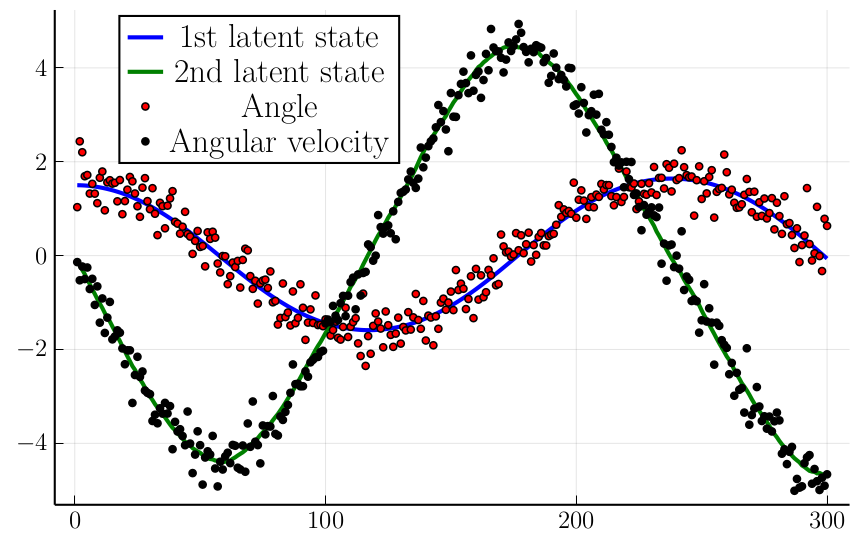

In [8]:
plot(getindex.(true_state_train,1), lw=2,label="1st latent state",color=:blue,
fontfamily="monospace",legendfontsize=16, tickfontsize=12,guidefontsize=16)
plot!(getindex.(true_state_train,2), lw=2, label="2nd latent state",color=:green)
scatter!(getindex.(y_train,1), markersize = 2.3, label="Angle", legend_position=(0.08,0.99),color=:red)
scatter!(getindex.(y_train,2), markersize = 2.3, label="Angular velocity",color=:black)
# scatter!(time_interval, getindex.(y_observation,2), size=[800,300], markersize = 1.8, label="observation")

In [9]:
savefig("../texfiles/pendulum_observation.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_observation.svg"

In [10]:
Xu_2_neg1 = reverse(collect(range(-4,0;length=12)));
Xu_2_neg2 = reverse(Xu_2_neg1) .+ 1e-5
Xu_2_pos1 = collect(range(1e-4,4;length=12));
Xu_2_pos2 = reverse(Xu_2_pos1)
Xu_2 = vcat(Xu_2_neg1,Xu_2_neg2,Xu_2_pos1,Xu_2_pos2)

Xu_1 = collect(range(-2,2;length=Int(length(Xu_2)/2)));
Xu_1 = vcat(reverse(Xu_1), Xu_1 .+ 1e-5);

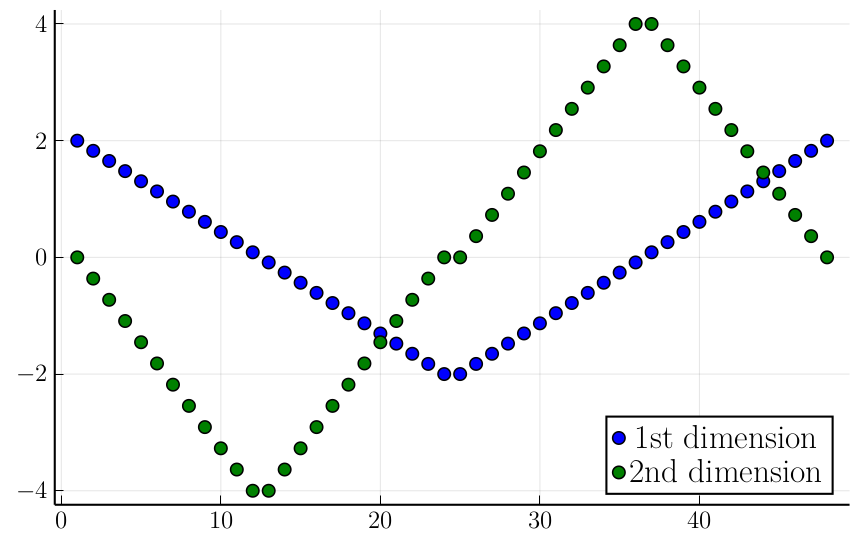

In [11]:
scatter(Xu_1,label="1st dimension", legend= :bottomright,color=:blue, fontfamily="monospace",legendfontsize=16,tickfontsize=12,guidefontsize=16)
scatter!(Xu_2,label="2nd dimension",color=:green)

In [12]:
savefig("../texfiles/pendulum_inducingpoint.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_inducingpoint.svg"

In [13]:
## 2-D data, fully observed
@model function pendulum_GP(y,dim_v,P,θ)
    v ~ MvNormalMeanCovariance(zeros(dim_v), 50*diageye(dim_v))
    W ~ Wishart(1e2,diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ MultiSGP(x_prev,v,W,θ)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [14]:
Xu = [[Xu_1[i],Xu_2[i]] for i=1:length(Xu_1)]

kernel_gp(θ) = StatsFuns.softplus(θ[1]) * with_lengthscale(SEKernel(), StatsFuns.softplus.(θ[2:end]))
gp_method = srcubature()
gp_cache = GPCache()

dim_v = size(Xu[1],1) * length(Xu)
M = length(Xu)
D = size(x_state[1],1)
Ψ0 = [1.0;;]
Ψ1_trans = kernelmatrix(kernel_gp([1.,1.]),Xu,[[1., 1.]])
Ψ2 = kernelmatrix(kernel_gp([1.,1.]),Xu,[[1., 1.]]) * kernelmatrix(kernel_gp([1.,1.]),[[1., 1.]],Xu)
;

In [15]:
@meta function gpssm_meta(method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel,cache)
    MultiSGP() -> MultiSGPMeta(method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,x_prev,v,W) = q(x)q(x_prev)q(v)q(W)
    q(x) = q(x[begin])..q(x[end])
end

gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(dim_v),50*diageye(dim_v))
    q(x) = MvNormalMeanCovariance(zeros(2), 50diageye(2))
    q(W) = Wishart(1e2,diageye(2))
end
;

## Optimize hyperparameter

In [16]:
function my_free_energy(θ)
    Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
    Kuu_inverse = cholinv(Kuu)
    infer_result_gp = infer(
        model = pendulum_GP(dim_v = dim_v,P = P, θ = θ,),
        iterations = 10,
        data = (y = y_train,),
        initialization = gp_initialization,
        meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
        constraints = gp_constraint,
        returnvars = (x_prev = KeepLast(),x = KeepLast(), v = KeepLast(), W = KeepLast()),
        free_energy = true,
    ) 
    
    return infer_result_gp.free_energy[end], infer_result_gp.posteriors[:x_prev], 
            infer_result_gp.posteriors[:x], infer_result_gp.posteriors[:v], infer_result_gp.posteriors[:W]
end

function PerformInference(θ; epochs)
    FE_value = []
    θ_optimal = θ
    grad = similar(θ)
    optimizer = Flux.AdaMax()
    @inbounds for epoch=1:epochs
            #step 1: Perform inference for v, w 
            fe, qx_prev, qx, qv, qW = my_free_energy(θ_optimal)
            #step 2: optimize the hyperparameters 
            gp_qy = mean.(qx) #for output of gp node
            gp_qx = vcat([qx_prev,qx[1:end-1]]...) #for input of gp node
            μ_v, Σ_v = mean_cov(qv)
            Rv = Σ_v + μ_v * μ_v' 
            W_bar = mean(qW)
            sumRv_Wbar = sum(create_blockmatrix(Rv,D,M) .* W_bar);
            for k=1:100
                grad_llh_multi!(grad,θ_optimal; y_data=gp_qy,
                                                qx = gp_qx,
                                                sumRv_Wbar = sumRv_Wbar,
                                                v = μ_v,
                                                W = W_bar,
                                                tr_W = tr(W_bar),
                                                kernel=kernel_gp,
                                                Xu=Xu,
                                                method=gp_method)
                Flux.Optimise.update!(optimizer,θ_optimal,grad)
            end
            append!(FE_value,fe)
    end
    return FE_value, θ_optimal
end

PerformInference (generic function with 1 method)

In [19]:
θ_init = StatsFuns.invsoftplus.([1.,1.,1.]);
@time FE_value, θ_optimal = PerformInference(θ_init;epochs=150); #approx 27 min

### If you can't wait, load the optimal hyperparameters
# θ_optimal = load("../savefiles/params_opt_pendulum.jld")["params"]

1615.249575 seconds (15.19 G allocations: 4.600 TiB, 32.22% gc time, 0.00% compilation time)


In [41]:
println("Optimal hyperparameters: ", StatsFuns.softplus.(θ_optimal))

Optimal hyperparameters: [0.5652780127184796, 2.2882645349850312, 4.751652857315865]


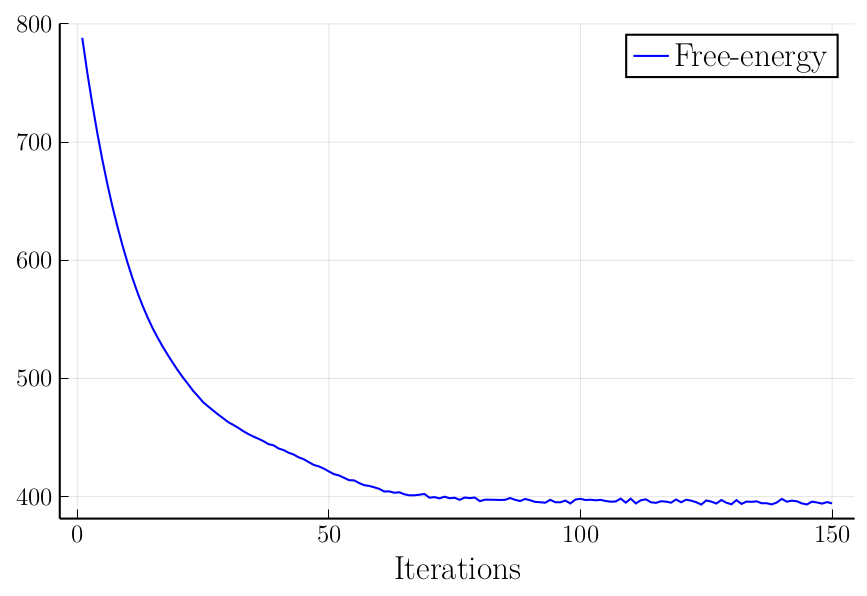

In [116]:
plot(FE_value, label="Free-energy",xlabel="Iterations",legend=:topright,color=:blue, legendfontsize=16, tickfontsize=12,guidefontsize=16)

In [117]:
savefig("../texfiles/pendulum_FE.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_FE.svg"

In [22]:
save("../savefiles/params_opt_pendulum.jld","params",θ_optimal)
save("../savefiles/FE_pendulum.jld","FE",FE_value)

## Inference for latent variables

In [17]:
niter = 30;
Kuu = kernelmatrix(kernel_gp(θ_optimal),Xu) + 1e-12*I
Kuu_inverse = cholinv(Kuu)

infer_result_gp = infer(
    model = pendulum_GP(dim_v = dim_v,P = P, θ = θ_optimal,),
    iterations = niter,
    data = (y = y_train,),
    initialization = gp_initialization,
    meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
    constraints = gp_constraint,
    returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


Inference results:
  Posteriors       | available for (v, W, x)
  Free Energy:     | Real[2996.43, 2216.39, 867.446, 600.92, 509.149, 462.585, 434.385, 415.904, 403.303, 394.701  …  375.902, 375.512, 375.497, 375.381, 375.135, 375.403, 375.566, 375.288, 375.309, 375.575]


In [18]:
qv_gp = infer_result_gp.posteriors[:v]
qx_gp = infer_result_gp.posteriors[:x];
qw_gp = infer_result_gp.posteriors[:W];

## Unscented Transform (known function)

In [19]:
@model function VMPsmoothing(y,P)
    W ~ Wishart(1e2, diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ MvNormalMeanPrecision(transition_function(x_prev), W)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [20]:
meta_VMPsmoothing = @meta begin
    transition_function() -> UT()
end

ut_constraint = @constraints begin
    q(x,x_prev,W) = q(x)q(x_prev)q(W)
    q(x) = q(x[begin])..q(x[end])
end

ut_initialization = @initialization begin
    q(W) = Wishart(1e2,diageye(2))
    q(x) = MvNormalMeanCovariance(zeros(2), 50*diageye(2))
end

infer_result_VMPsmoothing = infer(
    model = VMPsmoothing(P=P),
    data = (y = y_train,),
    meta = meta_VMPsmoothing,
    iterations = niter,
    constraints = ut_constraint,
    initialization = ut_initialization,
    returnvars = (x = KeepLast(), W = KeepLast(),),
    options = (limit_stack_depth=100,),
    free_energy = true
) 

qx_UT = infer_result_VMPsmoothing.posteriors[:x];
qw_UT = infer_result_VMPsmoothing.posteriors[:W]
;

## Result comparison 

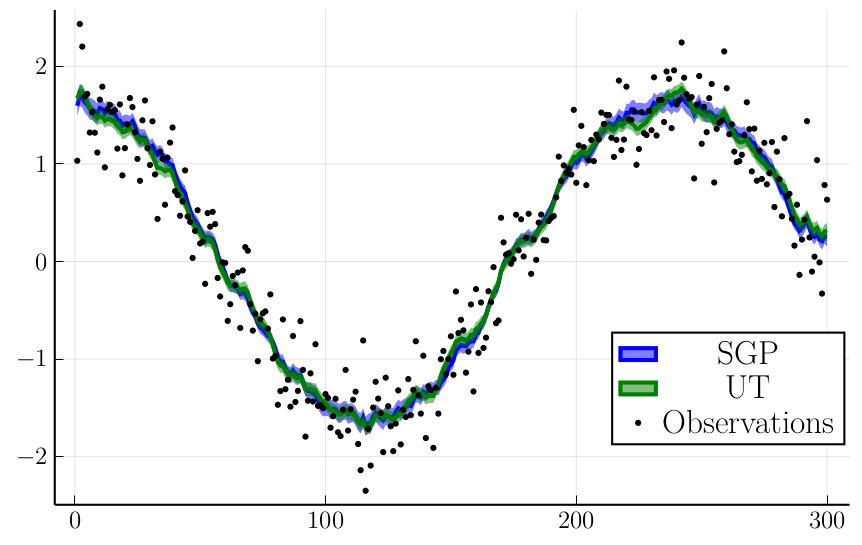

In [21]:
plot(getindex.(mean.(qx_gp),1),ribbon = sqrt.(getindex.(var.(qx_gp),1)),label="SGP",
     lw = 2,
     color=:blue)
plot!(getindex.(mean.(qx_UT),1),ribbon = sqrt.(getindex.(var.(qx_UT),1)),
    label="UT", lw = 2, legend_position=(0.7,0.35),
    color=:green,
    fontfamily="monospace",legendfontsize=16, tickfontsize=12,guidefontsize=16)


scatter!(getindex.(y_train,1), markersize=1.5, label="Observations",color=:black)

In [119]:
savefig("../texfiles/pendulum_1st_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1st_state.svg"

In [25]:
# function rmse_score(y_predict, y_true)
#     return sqrt(mean((y_predict - y_true).^2))
# end
include("gp_helperfunction.jl")
smse_UT_1st_state = SMSE(getindex.(true_state_train,1), getindex.(mean.(qx_UT),1))
smse_GPnode_1st_state = SMSE(getindex.(true_state_train,1), getindex.(mean.(qx_gp),1))
println("The smse of SGP node: $smse_GPnode_1st_state")
println("The smse of UT: $smse_UT_1st_state")

The smse of SGP node: 0.005454764265443909
The smse of UT: 0.006312814819631883


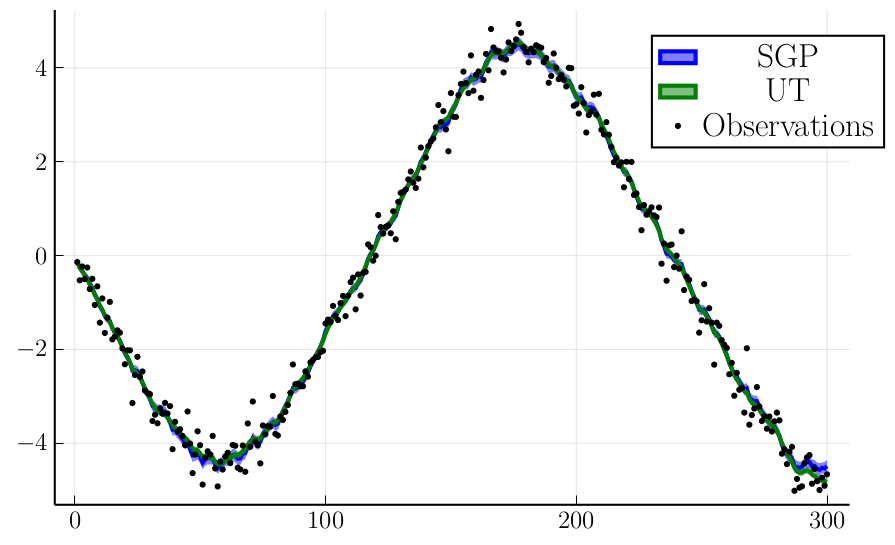

In [23]:
plot(getindex.(mean.(qx_gp),2),ribbon = sqrt.(getindex.(var.(qx_gp),2)),label="SGP", 
        lw = 2, color=:blue,
        fontfamily="monospace",legendfontsize=16,tickfontsize=12,guidefontsize=16)
plot!(getindex.(mean.(qx_UT),2),ribbon = sqrt.(getindex.(var.(qx_UT),2)),label="UT", 
                lw = 2, legend_position=(0.75,0.95), color=:green)
scatter!(getindex.(y_train,2), markersize=1.5, label="Observations", color=:black, alpha=1)

# plot!([collect(5:30),collect(5:30)],
#     [infer_result_VMPsmoothing.free_energy[5:30], infer_result_gp.free_energy[5:30]], 
#     label=["UT" "SGP"],
#     color=[:orange :blue],
#     lw= [1.5 1.5],
#     legend=:topright,
#     legend_font_pointsize=6,
#     inset = (1, bbox(0.4, 0.1, 0.4, 0.4, :bottom, :left)),
#     xlabel="Iterations",
#     ylabel="F[q]",
#     subplot = 2,
#     fontfamily="monospace",legendfontsize=9)

In [121]:
savefig("../texfiles/pendulum_2nd_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_2nd_state.svg"

In [26]:
smse_UT_2st_state = SMSE(getindex.(true_state_train,2), getindex.(mean.(qx_UT),2))
smse_GPnode_2st_state = SMSE(getindex.(true_state_train,2), getindex.(mean.(qx_gp),2))
println("The smse of SGP node: $smse_GPnode_2st_state")
println("The smse of UT: $smse_UT_2st_state")

The smse of SGP node: 0.0010773936260490339
The smse of UT: 0.0007997086456114025


## One- step-ahead prediction

In [33]:
prev_state = qx_gp[end]
predicted_state = []
for i=1:length(y_test)
    prediction = PredictState(prev_state,qv_gp,qw_gp,PointMass(θ_optimal), MultiSGPMeta(srcubature(),Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,GPCache()))
    push!(predicted_state,prediction)
    prev_state = UpdateState(prediction, y_test[i])
end

UT_predict_future = []
UT_var_predict_future = []
UT_prev_state = qx_UT[end]
for i=1:length(y_test)
    prediction = predict_UT(transition_function, UT_prev_state, qw_UT, UT())
    append!(UT_predict_future,mean(prediction)[1])
    append!(UT_var_predict_future,var(prediction)[1]) 
    UT_prev_state = UpdateState(prediction, y_test[i])
end
;

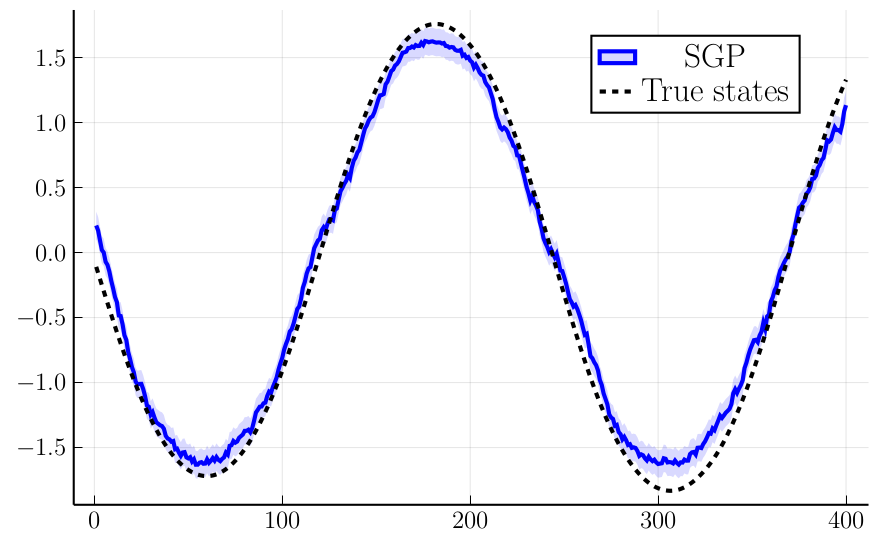

In [122]:
plot(getindex.(mean.(predicted_state),1),ribbon = sqrt.(getindex.(var.(predicted_state),1)) ,
        label="SGP",lw=2, color=:blue,legend_position=(0.65,0.95),
        fontfamily="monospace",legendfontsize=16, fillalpha=0.15,tickfontsize=12,guidefontsize=16)

# plot!(UT_predict_future,ribbon=sqrt.(UT_var_predict_future),
#     label="UT",lw=2, legend=:topleft, color=:green, fillalpha=0.15)

plot!(getindex.(true_state_test,1),label="True states", ls=:dash,lw=2, color=:black)
# xlabel!("t")

In [123]:
savefig("../texfiles/pendulum_1stepprediction.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1stepprediction.svg"

In [ ]:
# # function less_noise(var_y)
# #     #     P_local = var_y * diageye(2)
# #     #     x_state_local, y_observation_local = generate_data(N,x_init, Q,P_local);
# #     #     y_train_local = y_observation_local[1:n_train]
    
# #     #     function my_free_energy_local(θ)
        
# #     #         infer_result_gp = infer(
# #     #             model = pendulum_GP(dim_v = dim_v,P = P_local, θ = θ,),
# #     #             iterations = 10,
# #     #             data = (y = y_train_local,),
# #     #             initialization = gp_initialization,
# #     #             meta = gpssm_meta(srcubature(),Xu, C,kernel_gp,GPCache()),
# #     #             constraints = gp_constraint,
# #     #             free_energy = true,
# #     #         ) 
            
# #     #         return infer_result_gp.free_energy[end]
# #     #     end
    
# #     #     function learn_params_local(θ,iteration)
# #     #         lower = [0.1,0.1]
# #     #         upper = [10,10]
# #     #         res = optimize((x) -> my_free_energy_local(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iteration))
# #     #         return res.minimizer
# #     #     end
    
# #     #     θ_init = [1.,1.]
# #     #     θ_optimal_local = learn_params_local(θ_init,5)
    
# #     #     infer_result_gp_local = infer(
# #     #     model = pendulum_GP(dim_v = dim_v,P = P_local, θ = θ_optimal_local,),
# #     #     iterations = 30,
# #     #     data = (y = y_train_local,),
# #     #     initialization = gp_initialization,
# #     #     meta = gpssm_meta(srcubature(),Xu,C,kernel_gp,GPCache()),
# #     #     constraints = gp_constraint,
# #     #     returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
# #     #     free_energy = false,
# #     #     showprogress = true
# #     #     ) 
# #     #     qv_gp_local = infer_result_gp_local.posteriors[:v]
# #     #     qx_gp_local = infer_result_gp_local.posteriors[:x];
# #     #     qw_gp_local = infer_result_gp_local.posteriors[:W];
# #     #     return qv_gp_local, qx_gp_local, qw_gp_local, θ_optimal_local
# #     # end
# #     qv_gp_001, qx_gp_001, qw_gp_001, θ_optimal_001 = less_noise(0.01);
# # qv_gp_0001, qx_gp_0001, qw_gp_0001, θ_optimal_0001 = less_noise(0.001);
# # prev_state_001 = qx_gp_001[end]
# # _, y_observation_001 = generate_data(N,x_init, Q,0.01);
# # y_test_001 = y_observation_001[1+n_train:end]
# # predicted_state_001 = []
# # for i=1:length(y_test)
# #     prediction = PredictState(prev_state_001,qv_gp_001,qw_gp_001,PointMass(θ_optimal_001), MultiSGPMeta(srcubature(),Xu,C,kernel_gp,GPCache()))
# #     push!(predicted_state_001,prediction)
# #     prev_state_001 = UpdateState(prediction, y_test_001[i])
# # end

# # prev_state_0001 = qx_gp_0001[end]
# # _, y_observation_0001 = generate_data(N,x_init, Q,0.001);
# # y_test_0001 = y_observation_0001[1+n_train:end]
# # predicted_state_0001 = []
# # for i=1:length(y_test)
# #     prediction = PredictState(prev_state_0001,qv_gp_0001,qw_gp_0001,PointMass(θ_optimal_0001), MultiSGPMeta(srcubature(),Xu,C,kernel_gp,GPCache()))
# #     push!(predicted_state_0001,prediction)
# #     prev_state_0001 = UpdateState(prediction, y_test_0001[i])
# # end
# # plot(getindex.(mean.(predicted_state),1),ribbon = sqrt.(getindex.(var.(predicted_state),1)) , legend=:topleft,
# #         label="SGP (var_y = 0.1)",lw=2, color=:red,
# #         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# # plot!(getindex.(mean.(predicted_state_001),1),ribbon = sqrt.(getindex.(var.(predicted_state_001),1)) ,
# #         label="SGP (var_y = 0.01)",lw=2, color=:green,
# #         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# # plot!(getindex.(mean.(predicted_state_0001),1),ribbon = sqrt.(getindex.(var.(predicted_state_0001),1)) ,
# #         label="SGP (var_y = 0.001)",lw=2, color=:blue,
# #         fontfamily="monospace",legendfontsize=9, fillalpha=0.15)

# # plot!(getindex.(true_state_test,1),label="True states", ls=:dash,lw=2, color=:black)

# function my_free_energy(θ)
#     Kuu = kernelmatrix(kernel_gp(θ),Xu) + 1e-12*I
#     Kuu_inverse = cholinv(Kuu)
#     infer_result_gp = infer(
#         model = pendulum_GP(dim_v = dim_v,P = P, θ = θ,),
#         iterations = 10,
#         data = (y = y_train,),
#         initialization = gp_initialization,
#         meta = gpssm_meta(gp_method,Xu,Ψ0,Ψ1_trans,Ψ2,Kuu_inverse,kernel_gp,gp_cache),
#         constraints = gp_constraint,
#         returnvars = (x_prev = KeepLast(),x = KeepLast(), v = KeepLast(), W = KeepLast()),
#         free_energy = true,
#     ) 
    
#     return infer_result_gp.free_energy[end], infer_result_gp.posteriors[:x_prev], 
#             infer_result_gp.posteriors[:x], infer_result_gp.posteriors[:v], infer_result_gp.posteriors[:W]
# end

# function PerformInference(θ; epochs)
#     FE_value = []
#     # q_v = []
#     # q_w = []
#     θ_optimal = θ
#     grad = similar(θ)
#     optimizer = Flux.AdaMax()
#     @inbounds for epoch=1:epochs
#             #step 1: Perform inference for v, w 
#             fe, qx_prev, qx, qv, qW = my_free_energy(θ_optimal)
#             #step 2: optimize the hyperparameters 
#             gp_qy = mean.(qx) #for output of gp node
#             gp_qx = vcat([qx_prev,qx[1:end-1]]...) #for input of gp node
#             μ_v, Σ_v = mean_cov(qv)
#             Rv = Σ_v + μ_v * μ_v' 
#             W_bar = mean(qW)
#             sumRv_Wbar = sum(create_blockmatrix(Rv,D,M) .* W_bar);
#             llh_func = (x) -> neg_log_backwardmess_multi(x; y_data=gp_qy,
#                                                             qx = gp_qx,
#                                                             sumRv_Wbar = sumRv_Wbar,
#                                                             v = μ_v,
#                                                             W = W_bar,
#                                                             tr_W = tr(W_bar),
#                                                             kernel=kernel_gp,
#                                                             Xu=Xu,
#                                                             method=gp_method)
#             grad_func! = (G,x) -> grad_llh_multi!(G,x; y_data=gp_qy,
#                                                 qx = gp_qx,
#                                                 sumRv_Wbar = sumRv_Wbar,
#                                                 v = μ_v,
#                                                 W = W_bar,
#                                                 tr_W = tr(W_bar),
#                                                 kernel=kernel_gp,
#                                                 Xu=Xu,
#                                                 method=gp_method)
#             res = optimize(llh_func,grad_func!,θ_optimal,Optim.AdaMax(),Optim.Options(time_limit=10))
#             θ_optimal = res.minimizer
#             append!(FE_value,fe)
#     end
#     return FE_value, θ_optimal
# end

# θ_init = [1.,1.,1.];
# @time FE_value, θ_optimal = PerformInference(θ_init;epochs=200);

# rmse_UT_prediction = rmse_score(getindex.(true_state_test,1), UT_predict_future)
# rmse_GPnode_prediction = rmse_score(getindex.(true_state_test,1), getindex.(mean.(predicted_state),1))
# println("The rmse of SGP node: $rmse_GPnode_prediction")
# println("The rmse of UT: $rmse_UT_prediction")